In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Nelder Mead algorithm

首先定义N维的优化问题：

$$
    \min f, f: \mathbb{R}^N \to \mathbb{R}
$$

1. **初始化**：对于$N$维问题，定义$N+1$个点作为n-SIMPLEX的顶点： $x_1, x_2, \cdots, x_{N+1}$
2. **排序（检查截止）**：根据$f(x)$的值进行排序，使其有$f(x_1)\le f(x2) \le \cdots \le (f(x_{N+1}))$
3. **获取重心**，计算抛弃了最差点$x_{N+1}$之后的重心：$x_o = \frac{1}{n}\sum_{i}^{N}x_i$
4. **更新**
    - **三种单独更新操作**
        - 反射 (reflection): $x_r = x_o + \rho(x_o - x_{N+1})$。图像是从$x_o$出发沿$x_{N+1}\to x_o$方向反射
        - 扩展 (expansion): $x_e = x_o + \gamma(x_r - x_o)$。图像是从$x_o$出发沿$x_{o}\to x_r$方向扩展，所以要求$\gamma>1$
        - 收缩 (contraction): $x_c = x_o + \alpha(x_r - x_o)$。图像与扩展相同，但要求$\alpha < 1$
    - **整体更新操作**
        - 回退 (shrink): $x_i = x_1 + \sigma(x_i-x_1)$。图像是将所有点向最优点$x_1$靠拢，所以要求$\sigma < 1$
    - **更新策略**：首先进行反射操作：
        - 如果反射点为最优点：进行扩展，利用扩展点与反射点中最优的那个替换最差点
        - 如果反射点在最优点和第二差点之间：用反射点替换最差点
        - 如果反射点差于第二差点：计算收缩点
            - 如果收缩点优于第二差点则用收缩点替代最差点
            - 如果收缩点仍差与第二差点，则进行回退操作
            
# 超参数

- 固定型：
$$
\rho = 1,\ \gamma = 2,\ \alpha = 0.5, \ \sigma = 0.5
$$
- 自适应型：

$$
\rho = 1,\ \gamma = 1 + \frac{2}{n_{\mathrm{dim}}},\ \alpha = 0.75 - \frac{1}{2n_{\mathrm{dim}}},\ \sigma = 1 - \frac{1}{n_{\mathrm{dim}}}
$$

# 实现
## 定义目标函数

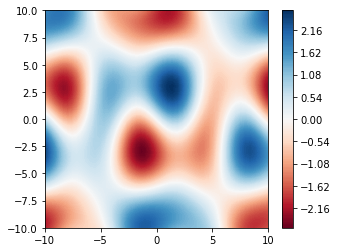

In [3]:
def objective_fun(x, y):
    return np.sin(x) * np.cos(0.2*y) + 2 * np.sin(0.5*y) * np.cos(0.3*x)

# Visualize target
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
x, y = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1, figsize=[5, 4])
c = ax.contourf(x, y, objective_fun(x, y), 200, cmap="RdBu")
fig.colorbar(c);

## 二维算法

In [13]:
class NelderMeadMinimizer:
    def __init__(
        self, objective_fun, num_dimensions: int, result_file_path: str = "minimize.npz"
    ) -> None:
        # Read input
        self._objective_fun = objective_fun
        self._num_dimensions = num_dimensions
        self._file_path = result_file_path
        # Set attributes
        self._simplex_history: list = []
        self._num_stored_vertices = 0
        self._num_vertices = self._num_dimensions + 1
        self._data_dimension = self._num_dimensions + 1
        self._vertex_history: np.ndarray = np.ones([0, self._data_dimension])
        # Row stands for the n+1 points in simplex
        # Col stands for the coordinate and data
        self._simplex_shape: list = [self._num_vertices, self._data_dimension]
        self._simplex: np.ndarray = np.zeros(self._simplex_shape)
        self._cur_centroid = np.ones(self._num_dimensions)
        # Hyper parameters
        self._rho = 1
        self._gamma = 1 + 2 / self._num_dimensions
        self._alpha = 0.75 - 1 / 2 / self._num_dimensions
        self._sigma = 1 - 1 / self._num_dimensions

    def generate_vertex(self, coordinate: np.ndarray):
        is_stored = False
        # Check whether this vertex is stored
        for i in range(self._num_stored_vertices):
            if np.all(self._vertex_history[i, : self._num_dimensions] == coordinate):
                vertex = self._vertex_history[i, :]
                is_stored = True
                break
        # Calculate and add unstored vertex
        if not is_stored:
            value = self._objective_fun(*list(coordinate))
            vertex = np.ones([1, self._data_dimension])
            vertex[0, : self._num_dimensions] = coordinate[:]
            vertex[0, self._num_dimensions] = value
            self._vertex_history = np.vstack([self._vertex_history, vertex])
            self._vertex_history = self._vertex_history[
                self._vertex_history[:, self._num_dimensions].argsort()
            ]
            self._num_stored_vertices += 1
        return vertex.flatten()

    def initialize(self, simplex: np.ndarray):
        if (
            simplex.shape[0] != self._num_vertices
            or simplex.shape[1] != self._num_dimensions
        ):
            raise KeyError(
                "A %s array required, while %s is provided"
                % ((self._num_vertices, self._num_dimensions), simplex.shape)
            )
        self._simplex[:, : self._num_dimensions] = simplex
        for i in range(self._num_vertices):
            self._simplex[i, :] = self.generate_vertex(
                self._simplex[i, : self._num_dimensions]
            )
        self.sort()

    def sort(self) -> bool:
        sorted_arg = self._simplex[:, self._num_dimensions].argsort()
        self._simplex = self._simplex[sorted_arg]
        is_stored = False
        for simplex in self._simplex_history:
            if np.all(simplex == self._simplex):
                is_stored = True
                break
        if not is_stored:
            self._simplex_history.append(self._simplex.copy())
        self._cur_centroid = np.mean(
            self._simplex[: self._num_vertices - 1, : self._num_dimensions], axis=0
        )
        return sorted_arg[0] == 0

    def shrink(self) -> None:
        best_point = self._simplex[0, : self._num_dimensions]
        for i in range(self._num_vertices):
            shrink_point = best_point + self._sigma * (
                self._simplex[i, : self._num_dimensions] - best_point
            )
            self._simplex[i, :] = self.generate_vertex(shrink_point)

    def reflect(self) -> np.ndarray:
        reflect_point = self._cur_centroid + self._rho * (
            self._cur_centroid - self._simplex[-1, : self._num_dimensions]
        )
        return self.generate_vertex(reflect_point)

    def expand(self, reflect_point) -> np.ndarray:
        expand_point = self._cur_centroid + self._gamma * (
            reflect_point - self._cur_centroid
        )
        return self.generate_vertex(expand_point)

    def contract(self, reflect_point) -> np.ndarray:
        contract_point = self._cur_centroid + self._alpha * (
            reflect_point - self._cur_centroid
        )
        return self.generate_vertex(contract_point)

    def _check_simplex_difference(self, difference_tolerance):
        value = self._simplex[:, self._num_dimensions]
        mean = np.mean(value)
        return np.abs((value - mean) / (mean + 1e-9)).max() <= difference_tolerance

    def minimize(
        self,
        max_iteration=100,
        error_tolerance=1e-3,
        unchanged_iterations_tolerance=10,
        simplex_difference_tolerance=1e-3,
    ):
        num_unchanged_iteration = 0
        for iteration in range(max_iteration):
            pre_coordinate = self._simplex[0, : self._num_dimensions]
            reflect_vertex = self.reflect()
            reflect_point = reflect_vertex[: self._num_dimensions]
            reflect_value = reflect_vertex[self._num_dimensions]
            if reflect_value <= self._simplex[0, self._num_dimensions]:
                # The reflect point is better than the best point
                expand_vertex = self.expand(reflect_point)
                if reflect_value <= expand_vertex[self._num_dimensions]:
                    self._simplex[-1, :] = reflect_vertex
                else:
                    self._simplex[-1, :] = expand_vertex
            elif reflect_value < self._simplex[-2, self._num_dimensions]:
                # The reflect point is between best and the penultimate worst
                self._simplex[-1, :] = reflect_vertex
            else:
                # The reflect point is worse than the penultimate worst
                contract_vertex = self.contract(reflect_point)
                if (
                    contract_vertex[self._num_dimensions]
                    < self._simplex[-2, self._num_dimensions]
                ):
                    self._simplex[-1, :] = contract_vertex
                else:
                    self.shrink()
            is_unchanged = self.sort()
            if is_unchanged:
                num_unchanged_iteration += 1
            else:
                num_unchanged_iteration = 0
            if num_unchanged_iteration >= unchanged_iterations_tolerance:
                break
            if is_unchanged and self._check_simplex_difference(
                simplex_difference_tolerance
            ):
                break
        print("Final coordinate:", self._simplex[0, : self._num_dimensions])
        print("Final value:", self._simplex[0, self._num_dimensions])
        print("Total calculation counts: %d" % self._num_stored_vertices)

    def save(self):
        np.savez(
            self._file_path,
            simplex_history=np.stack(self._simplex_history),
            vertex_history=self._vertex_history,
        )

    def load(self):
        data = np.load(self._file_path)
        self._simplex_history = [i for i in data["simplex_history"]]
        self._vertex_history = data["vertex_history"]
        self._num_stored_vertices = self._vertex_history.shape[0]
        print(self._vertex_history)

    @property
    def simplex(self):
        return self._simplex

    @property
    def simplex_history(self):
        return self._simplex_history

In [14]:
def visulize_minimization(minimizer):
    # Visualize minimization
    x = np.linspace(-10, 10, 50)
    y = np.linspace(-10, 10, 50)
    x, y = np.meshgrid(x, y)
    z = objective_fun(x, y)

    num_simplex = 8
    fig_col = 2
    fig_row = num_simplex // fig_col
    fig, ax = plt.subplots(fig_row, fig_col, figsize=[6, 12])

    for index, simplex in enumerate(minimizer.simplex_history[:num_simplex]):
        row, col = index // fig_col, index % fig_col
        ax[row, col].contourf(x, y, z, 200, cmap="RdBu")
        if index > 0:
            pre_simplex = minimizer.simplex_history[index - 1]
            triangle = np.vstack([pre_simplex[:, :2], pre_simplex[0, :2]])
            ax[row, col].plot(triangle[:, 0], triangle[:, 1], "pink")
        triangle = np.vstack([simplex[:, :2], simplex[0, :2]])
        ax[row, col].plot(triangle[:, 0], triangle[:, 1], 'teal')

Final coordinate: [-1.28125  -2.921875]
Final value: -2.642227051457176
Total calculation counts: 30


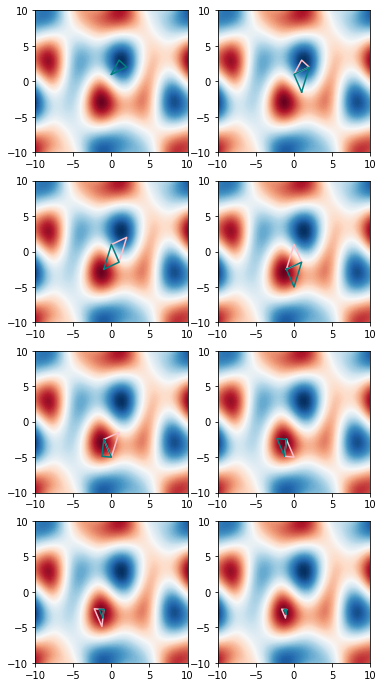

In [15]:
minimizer = NelderMeadMinimizer(objective_fun=objective_fun, num_dimensions=2)
minimizer.initialize(np.array([[2, 2], [0, 1], [1, 3]]))
minimizer.minimize()
visulize_minimization(minimizer)

## 局部最小问题

Nelder-Mead方法不能很好的处理非凸函数的局部最小值问题，最终结果会对初始值敏感

Final coordinate: [10.90820312  2.91992188]
Final value: -2.801821153244531
Total calculation counts: 59


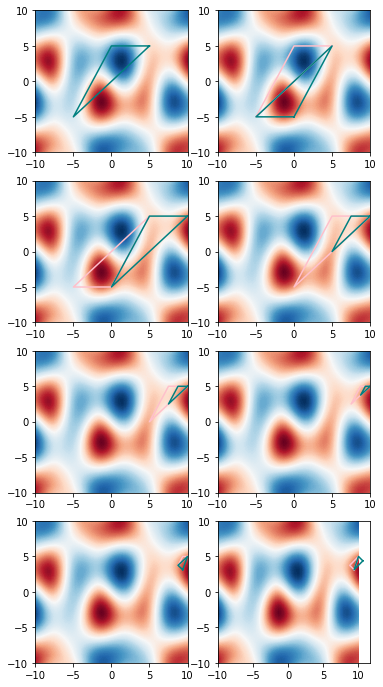

In [16]:
minimizer = NelderMeadMinimizer(objective_fun=objective_fun, num_dimensions=2)
minimizer.initialize(np.array([[5, 5], [-5, -5], [5, -5]]))
minimizer.minimize()
visulize_minimization(minimizer)